In [1]:
# import os, sys
# sep = os.sep
# # Добавить в путь до родительской папки\n",
# sys.path.append(os.path.join(sys.path[0], f'..{sep}'))
# #sys.path.append(os.path.join(os.getcwd(), f'..{sep}'))

In [2]:
import os
#
import numpy as np
import matplotlib.pyplot as plt
#
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
#
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

%matplotlib inline

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 4	GANs to Generate Color Images of Anime Faces

In [4]:
pass

## 4.1 Download Anime Faces

In [5]:
# Download data from https://www.kaggle.com/datasets/splcher/animefacedataset
# Скачать и распаковать архив в папку '../data/ch04/anime/images'
anime_path = f'..{os.sep}data{os.sep}ch04{os.sep}anime'

In [6]:
transform = T.Compose([
    # Все изображения привести к одному размеру 64х64
    T.Resize((64, 64)),
    # Converts image pixels to PyTorch tensors
    # From range [0, 255] to range [0.0, 1.0]
    T.ToTensor(),
    # Normalizes the values to the range [–1.0, 1.0]
    # Вычитаем 0.5 из данных и разделить разницу на 0.5
    # В каждом массиве 3 числа - по одному на каждый цветовой канал
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Нормализация входных данных до диапазона [–1, 1]
# позволяет градиентному спуску работать более эффективно

In [7]:
# Создали Dataset
# Конечный каталог '/images/' не включен в anime_path
train_data = ImageFolder(root=anime_path, transform=transform)

In [8]:
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

## 4.2 Channels First Color Images

In [9]:
image0, _ = train_data[0]
print(image0.shape)

torch.Size([3, 64, 64])


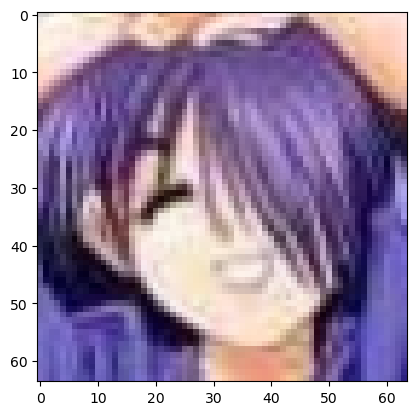

In [10]:
# permute(1, 2, 0): Перместить цветовой канал в конец. CxHxW => HxWxC
# Числа из диапазона [-1.0, 1.0] переводим в диапазон [0.0, 1.0]
plt.imshow(image0.permute(1, 2, 0)*0.5 + 0.5)
#plt.axis('off')
plt.show();

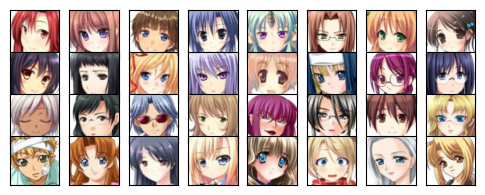

In [11]:
fig = plt.figure(figsize=(6, 3), dpi=100)
def plot_images(imgs):
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        # permute(1, 2, 0): Перместить цветовой канал в конец. CxHxW => HxWxC
        # Числа из диапазона [-1.0, 1.0] переводим в диапазон [0.0, 1.0]
        plt.imshow(imgs[i].permute(1, 2, 0)/2 + 0.5)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.show();

# Получили batch_size картинок
imgs, _ = next(iter(train_loader))
plot_images(imgs)

# 5	Deep Convolutional GAN (DCGAN) 

In [12]:
pass

## 5.1 Building a DCGAN

In [13]:
# Discriminator D is binary classifier
D = nn.Sequential(
    # Входом является цветное изображение с тремя цветовыми каналами.
    # (Условно для сверточного слоя, размер изображения НЕ имеет значения)
    nn.Conv2d(
        # Количество каналов во входном изображении
        in_channels=3,
        # Количество каналов после сверточного слоя, которое может принимать любое число
        # в зависимости от того, сколько признаков мы предполагаем извлечь из изображения
        out_channels=64,
        # Размер ядра: например, kernel_size=3 означает, что фильтр имеет форму 3×3,
        kernel_size=4,
        # Аргумент шага указывает, на сколько пикселей нужно сместиться вправо или вниз
        # каждый раз, когда фильтр перемещается по входному изображению
        # default=1
        stride=2,
        # Сколько строк\колонок с нулями добавить к четырем сторонам входного изображения,
        # default=0
        padding=1,
        # default=True
        bias=False),
    # if x < 0: x = negative_slope*x
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    
    # Нормализация выполняется независимо для каждого цветового канала
    # путем корректировки и масштабирования значений в канале таким образом,
    # чтобы они имели среднее значение 0 и дисперсию 1
    nn.BatchNorm2d(num_features=128),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=256),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=512),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
    # Сжать число на выходе до диапазона [0.0, 1.0]
    nn.Sigmoid(),
    # Преобразовать матрицу 1х1 в вектор
    nn.Flatten()
).to(device)

In [14]:
# Генератор пытается минимизировать вероятность того, что
# поддельный образец будет идентифицирован как поддельный
G = nn.Sequential(
    # На входе будет 100 чисел (случайного шума), каждое число это матрица 1х1.
    # Если изменнить кол-во чисел, например на 500 или 1000 - это недолжно повлият на результат.
    #
    # В остальном первый слой генератора моделируется по образцу последнего слоя дискриминатора.
    nn.ConvTranspose2d(
        in_channels=100, out_channels=512, kernel_size=4,
        # Управление объемом частоты дискретизации. Чем больше значение шага,
        # тем больше повышение частоты дискретизации 
        stride=1, # default=1
        padding=0, # default=0
        bias=False # default=True
    ),
    # Нормализация выполняется независимо для каждого цветового канала
    # путем корректировки и масштабирования значений в канале таким образом,
    # чтобы они имели среднее значение 0 и дисперсию 1
    nn.BatchNorm2d(num_features=512),
    nn.ReLU(inplace=True),

    # Второй слой генератора симметричен предпоследнему слою дискриминатора
    # (номера входов и выходов поменялись местами).
    nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=256), nn.ReLU(inplace=True),

    # и т.д
    nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=128), nn.ReLU(inplace=True),
    
    nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=64), nn.ReLU(inplace=True),

    # Последний слой генератора симметричен первому слою дискриминатора.
    nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),

    # Сжать каждое число на выходе до диапазона [-1.0, 1.0]
    # - как у тренировочных данных
    nn.Tanh()
).to(device)

# За исключением входных значений генератора и выходного значения дискриминатора,
# все остальные слои ConvTranspose2d в генераторе зеркально отражают слои Conv2d в дискриминаторе!

In [15]:
# Комментарий лично для себя! Возможно понимаю неправильно...
# Если nn.Conv2d сворачиваеть изображение - изменяет его размеры
# То nn.ConvTranspose2d с теми же значениями - возвращаеть исходные размеры
# (если in_channels и out_channels поменять местам)

In [16]:
lr = 0.0002
# betas: Контролируем, насколько большое внимание уделяется
# недавней по сравнению с прошлой информацией о градиенте
# 0.5: past gradient information
# 0.999: recent gradient information
optimD = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
optimG = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss Function for Discriminator and Generator (для Backpropagation)
# Binary cross-entropy loss function (Кросс-энтропия для бинарной классификации)
loss_fn = nn.BCELoss()

In [32]:
# Для себя
for n, (real_samples, _) in enumerate(train_loader):
    print(real_samples.shape)
    preds = D(real_samples.to(device))
    print(preds.shape)
    break

torch.Size([128, 3, 64, 64])
torch.Size([128, 1])


## 5.2 Training and using DCGAN

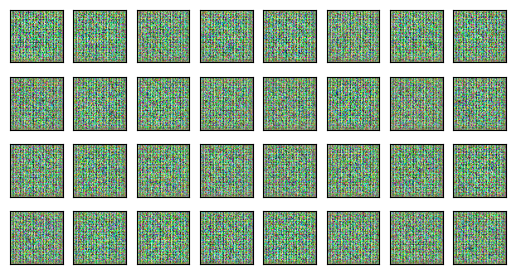

In [17]:
# Функция выводит 32 изображения, которые сгенерировал Generator
def test_epoch():
    #fig = plt.figure(figsize=(8, 4), dpi=100)
    # Нормальное распределение с mean=1, std=1
    # 1, 1: 100 матриц двумерных матриц размером 1х1
    noise = torch.randn(32, 100, 1, 1).to(device=device)

    # Generator генерирует данные
    # 32 цветных изображения
    fake_samples = G(noise).cpu().detach()
    
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        
        # fake_samples[i]/2 + 0.5: Числа из диапазона [-1.0, 1.0] переводим в диапазон [0.0, 1.0]
        # permute(1, 2, 0): Перместить цветовой канал в конец. CxHxW => HxWxC
        img = (fake_samples[i]/2 + 0.5).permute(1, 2, 0)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

    plt.subplots_adjust(hspace=-0.6)
    plt.show();

test_epoch()

In [18]:
# Метки для истинных образцов
real_labels = torch.ones((batch_size, 1)).to(device)
# Метки для сгенерированных образцов
fake_labels = torch.zeros((batch_size, 1)).to(device)

In [19]:
# Один шаг тренировки Discriminator на истинных данных
def train_D_on_real(real_samples):
    real_samples = real_samples.to(device)
    # Работа дискриминатора (здесь он должен выдать вероятности близкие к 1)
    preds = D(real_samples)
    
    labels1 = torch.ones((real_samples.shape[0], 1)).to(device)

    # Backpropagation
    optimD.zero_grad()
    # labels1: Все 1
    loss_D = loss_fn(preds, labels1)
    loss_D.backward()
    optimD.step()  # Изменяем веса дискриминатора
    
    return loss_D  

In [20]:
# Один шаг тренировки Discriminator на сгенерированных данных
def train_D_on_fake():
    # Нормальное распределение с mean=1, std=1
    # 1, 1: 100 матриц двумерных матриц размером 1х1
    noise = torch.randn(batch_size, 100, 1, 1).to(device)
    # Generator генерирует данные
    fake_samples = G(noise)
    # Работа дискриминатора (здесь он должен выдать вероятности близкие к 0)
    preds = D(fake_samples)

    # Backpropagation
    optimD.zero_grad()
    # fake_labels: Все 0
    loss_D = loss_fn(preds, fake_labels)
    loss_D.backward()
    optimD.step()  # Изменяем веса дискриминатора
    
    return loss_D 

In [21]:
# Один шаг тренировки Generator на сгенерированных данных
def train_G():
    # Нормальное распределение с mean=1, std=1
    # 1, 1: 100 матриц двумерных матриц размером 1х1
    noise = torch.randn(batch_size, 100, 1, 1).to(device)
    # Generator генерирует данные
    # Задача генератора обмануть дискриминатор
    # (чтобы он поддельные данные принял за истинные)
    fake_samples = G(noise)
    # Работа дискриминатора
    # Возвращает вероятности того, что сгенерированные
    # данные являются истинными
    preds = D(fake_samples)

    # Backpropagation
    optimG.zero_grad()
    # real_labels: Все 1
    loss_G = loss_fn(preds, real_labels)
    loss_G.backward()
    optimG.step()  # Изменяем веса генератора
    
    return loss_G

1, 2, 3, 4, Epoch 5 => d_loss: 0.33584147691726685; g_loss 7.222308158874512


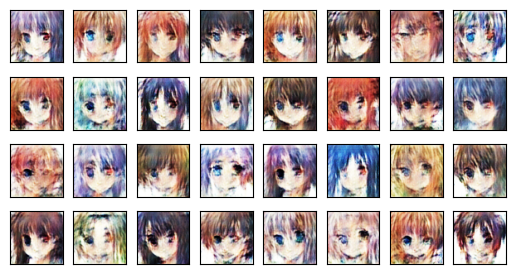

6, 7, 8, 9, Epoch 10 => d_loss: 0.35131964087486267; g_loss 6.579429626464844


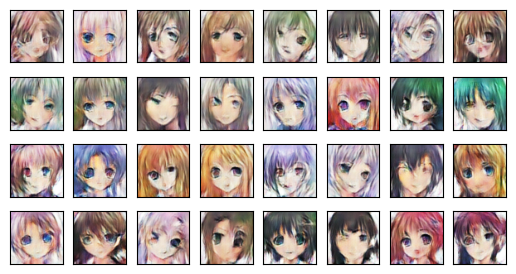

11, 12, 13, 14, Epoch 15 => d_loss: 0.32828304171562195; g_loss 6.3395514488220215


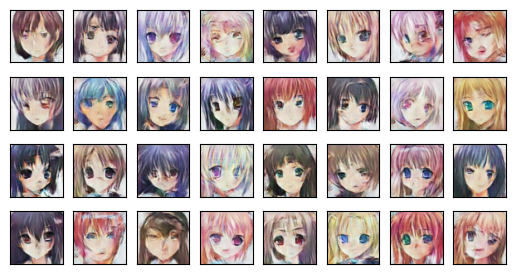

16, 17, 18, 19, Epoch 20 => d_loss: 0.30888989567756653; g_loss 5.855886936187744


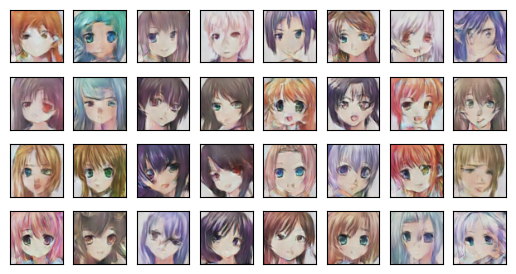

In [22]:
n_epoch = 20
for epoch in range(1, n_epoch+1):
    g_loss = 0
    d_loss = 0
    for n, (real_samples, _) in enumerate(train_loader):    
        loss_D = train_D_on_real(real_samples)
        d_loss += loss_D
        loss_D = train_D_on_fake()
        d_loss += loss_D
        loss_G = train_G()
        g_loss += loss_G
    
    g_loss = g_loss/n
    d_loss = d_loss/n

    if epoch % 5 == 0:
        print(f'Epoch {epoch} => d_loss: {d_loss}; g_loss {g_loss}')
        test_epoch()
    else:
        print(epoch, end=', ')

In [23]:
# Save Trained Model
dir_name = 'files'
file_name = 'anime_gen.pth'
os.makedirs(dir_name, exist_ok=True)

# Метод torch.jit.script() создает скрипт функции
# или класса nn.Module как код TorchScript
# с использованием компилятора TorchScript.
scripted = torch.jit.script(G) 
scripted.save(f'{dir_name}{os.sep}{file_name}')

In [24]:
# Load Trained Model
# Чтобы загрузить модель, даже не нужно ее определять. Просто загружаем сохраненный файл
new_G = torch.jit.load(f'{dir_name}{os.sep}{file_name}', map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=ConvTranspose2d)
  (1): RecursiveScriptModule(original_name=BatchNorm2d)
  (2): RecursiveScriptModule(original_name=ReLU)
  (3): RecursiveScriptModule(original_name=ConvTranspose2d)
  (4): RecursiveScriptModule(original_name=BatchNorm2d)
  (5): RecursiveScriptModule(original_name=ReLU)
  (6): RecursiveScriptModule(original_name=ConvTranspose2d)
  (7): RecursiveScriptModule(original_name=BatchNorm2d)
  (8): RecursiveScriptModule(original_name=ReLU)
  (9): RecursiveScriptModule(original_name=ConvTranspose2d)
  (10): RecursiveScriptModule(original_name=BatchNorm2d)
  (11): RecursiveScriptModule(original_name=ReLU)
  (12): RecursiveScriptModule(original_name=ConvTranspose2d)
  (13): RecursiveScriptModule(original_name=Tanh)
)

In [25]:
# Для себя (чтобы понять)!!!
new_G.eval()
noise = torch.randn(1, 100, 1, 1).to(device=device)
fake_samples = G(noise)
# Одно цветное изображение: 3 цветовых канала, высота, ширина 64х64
fake_samples.shape

torch.Size([1, 3, 64, 64])

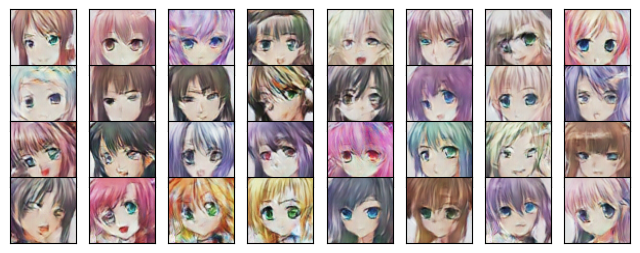

In [27]:
new_G.eval()

fig = plt.figure(figsize=(8, 4), dpi=100)
# Нормальное распределение с mean=1, std=1
# 1, 1: 100 матриц двумерных матриц размером 1х1
noise = torch.randn(32, 100, 1, 1).to(device=device)

# Generator генерирует данные
# 32 цветных изображения
fake_samples = G(noise).cpu().detach()

for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    
    # fake_samples[i]/2 + 0.5: Числа из диапазона [-1.0, 1.0] переводим в диапазон [0.0, 1.0]
    # permute(1, 2, 0): Перместить цветовой канал в конец. CxHxW => HxWxC
    img = (fake_samples[i]/2 + 0.5).permute(1, 2, 0)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

plt.subplots_adjust(hspace=-0.6)
plt.show();